## Imports

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
from PIL import Image

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

## Hyperparameters

In [2]:
directory_path = os.environ['DATASET_PATH']
image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.jpg')]


EPOCHS = 1000
NOISE_DIM = 100
BATCH_SIZE = 64

MAX_SIZE = 10000

# Select percentage of data to use in each epoch
RANDOM_SELECT = 0.5

INITIAL_TRAIN_RATIO = 5
INITIAL_EPOCHS = 100
TRAIN_DECAY = 0.8
TRAIN_DECAY_EPOCHS = 25


INTERVAL = 50

## Models

### Discriminator

In [3]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3,)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

In [4]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)            0

### Generator

In [5]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(32*32*512, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((32, 32, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])

    return model

In [6]:
generator = make_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 524288)            52428800  
                                                                 
 batch_normalization (BatchN  (None, 524288)           2097152   
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 524288)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      3276800   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)     

## Loss Functions and Optimizers

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_object = tf.keras.losses.BinaryCrossentropy()

### Continute Training

In [8]:
TRAINING_RESUME = False
epoch = 0

if(TRAINING_RESUME):
    generator.load_weights(os.path.join(os.environ['CHECKPOINT_PATH'], f"generator_decay_based_{epoch}.h5"))
    discriminator.load_weights(os.path.join(os.environ['CHECKPOINT_PATH'], f"discriminator_decay_based_{epoch}.h5"))

In [9]:
## Discriminator setup
discriminator.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])
discriminator.trainable = False

In [10]:
## Generator setup
noise = layers.Input(shape=(NOISE_DIM,))
image = generator(noise)

## Combined model
validity = discriminator(image)
combined = tf.keras.Model(noise, validity)
combined.compile(optimizer=optimizer, loss=loss_object)

## Utility Functions

In [11]:
def discriminator_train(epoch):
    if epoch < INITIAL_EPOCHS:
        ratio = INITIAL_TRAIN_RATIO
    
    else:
        ratio = max(1,INITIAL_TRAIN_RATIO * TRAIN_DECAY ** ((epoch - INITIAL_EPOCHS) // TRAIN_DECAY_EPOCHS))
    
    return (epoch%ratio == 0)

In [12]:
def sample_image(epoch):
    noise = np.random.normal(0, 1, (1, NOISE_DIM))

    gen_imgs = generator.predict(noise, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig = gen_imgs[0]
    im = Image.fromarray((fig * 255).astype(np.uint8))

    path = os.path.join(os.environ['SAMPLES_PATH'], f"image_decay_based_{epoch}.jpg")
    im.save(path)

In [13]:
## Create batches of images from directory

def create_batches(images, batch_size=BATCH_SIZE):
    while True:
        for i in range(0, MAX_SIZE, batch_size):
            batch_images = image_files[i:i+batch_size]
            batch = np.array([imread(file_name) for file_name in batch_images])
            batch = (batch.astype(np.float32) - 127.5) / 127.5
            yield batch

In [14]:
def create_checkpoint(generator, discriminator,epoch):
    path = os.path.join(os.environ['CHECKPOINT_PATH'], f"generator_decay_based_{epoch}.h5")
    generator.save(path)

    path = os.path.join(os.environ['CHECKPOINT_PATH'], f"discriminator_decay_based_{epoch}.h5")
    discriminator.save(path)


## Training the model

In [15]:
real = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

discriminator_loss = []
discriminator_accuracy = []
generator_loss = []

image_files = np.array(image_files)

In [16]:
reshapeModel = tf.keras.Sequential([layers.Resizing(128,128, input_shape=(218,178,3,))])

In [ ]:
for epoch in range(EPOCHS):

    print(f"----------- Epoch {epoch+1} -----------")

    epoch_images = np.random.choice(image_files, int(MAX_SIZE*RANDOM_SELECT), replace=False)

    imgGenerator = create_batches(epoch_images)

    discriminator_batch_loss = []
    discriminator_batch_acc = []
    generator_batch_loss = []

    for i in range (len(epoch_images)//BATCH_SIZE):

        imgs = next(imgGenerator)
        imgs = reshapeModel(imgs)

        noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))

        discriminator.trainable = discriminator_train(epoch+1)

        gen_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        discriminator.trainable = False

        g_loss = combined.train_on_batch(noise, real)

        discriminator_batch_loss.append(d_loss[0])
        generator_batch_loss.append(g_loss)
        discriminator_batch_acc.append(d_loss[1])

    discriminator_loss.append(np.mean(discriminator_batch_loss))
    generator_loss.append(np.mean(generator_batch_loss))
    discriminator_accuracy.append(np.mean(discriminator_batch_acc))


    print(f"Discriminator loss: {discriminator_loss[epoch]}   Accuracy: {discriminator_accuracy[epoch]}")
    print(f"Generator loss: {generator_loss[epoch]}")
    print('---------------------------------------')

    if((epoch+1) % INTERVAL==0):
        sample_image(epoch+1)
        create_checkpoint(generator, discriminator, epoch+1)

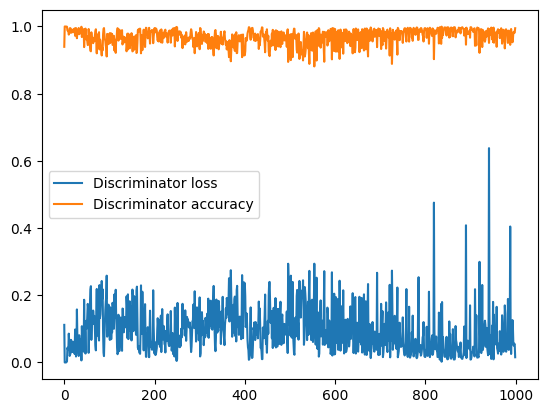

In [18]:
## Plot loss and accuracy

plt.plot(discriminator_loss, label='Discriminator loss')
plt.plot(discriminator_accuracy, label='Discriminator accuracy')

plt.legend()
plt.show()